In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train=pd.read_csv(r'D:\Downloads\Compressed\attrition prediction\Dataset\Train.csv')
test=pd.read_csv(r'D:\Downloads\Compressed\attrition prediction\Dataset\Test.csv')
sample=pd.read_csv(r'D:\Downloads\Compressed\attrition prediction\Dataset\Sample_submission.csv')

In [4]:
train.head()

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,...,type2,3.0,4,0.7516,1.8688,2.0,4,5,3,0.1841
1,EID_18000,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,...,type2,4.0,3,-0.9612,-0.4537,2.0,3,5,3,0.0670
2,EID_3891,F,58.0,3,Married,Clinton,Quality,Conceptual,27.0,3,...,type2,1.0,4,-0.9612,-0.4537,3.0,3,8,3,0.0851
3,EID_17492,F,26.0,3,Single,Lebanon,Human Resource Management,Behavioral,4.0,3,...,type2,1.0,3,-1.8176,-0.4537,NaN,3,7,3,0.0668
4,EID_22534,F,31.0,1,Married,Springfield,Logistics,Conceptual,5.0,4,...,type3,3.0,1,0.7516,-0.4537,2.0,2,8,2,0.1827


In [5]:
sample.head()

,Employee_ID,Attrition_rate
0,TID_1,0.1588
1,TID_2,0.1424
2,TID_3,0.4758
3,TID_4,0.0846
4,TID_5,0.2388


In [6]:
train.shape

(7000, 24)

# Absolute base model

# Label encoding

In [7]:
traindf=train.copy()
testdf=test.copy()

In [8]:
traindf.drop('Employee_ID',axis=1,inplace=True)
testdf.drop('Employee_ID',axis=1,inplace=True)

In [9]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
cat_features=traindf.columns[traindf.dtypes==object]
for col in cat_features:
    le.fit(traindf[col])
    testdf[col]=le.transform(testdf[col])
    traindf[col]=le.transform(traindf[col])

In [10]:
feature=traindf.drop('Attrition_rate',axis=1)
label=traindf.Attrition_rate

In [11]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train,X_test,y_train,y_test=train_test_split(feature,label)
lgb=LGBMRegressor(max_depth=5,learning_rate=.01,n_estimators=100,subsample_for_bin=3000,subsample=.6,colsample_bytree=.6)
lgb.fit(X_train,y_train)
y_pred=lgb.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred))

0.18386978573502039

# Gridsearchcv

In [12]:
from sklearn.model_selection import GridSearchCV
params={'max_depth':[3,5,8],'learning_rate':[.1,.01],'n_estimators':[100,300,500],'subsample_for_bin':[3000,5000,7000],'subsample':[.6,.8],'colsample_bytree':[.6,.8,1]}
gs=GridSearchCV(lgb,params,scoring='neg_mean_squared_error').fit(feature,label)

In [13]:
gs.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 100,
 'subsample': 0.6,
 'subsample_for_bin': 3000}

# Xgboost

In [14]:
import xgboost as xgb
dmatrix=xgb.DMatrix(feature,label)
params={'objective':'reg:squarederror','max_depth':5,'colsample_bytree':.8,'eta':.02,'alpha':1}
result=xgb.cv(params,dmatrix,num_boost_round=1000,early_stopping_rounds=20,as_pandas=True,nfold=3)
result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.356608,0.000292,0.356607,0.000597
1,0.351429,0.000289,0.351429,0.000601
2,0.346383,0.000286,0.346383,0.000606
3,0.341467,0.000283,0.341466,0.000610
4,0.336677,0.000281,0.336677,0.000614
...,...,...,...,...
190,0.174988,0.000967,0.186422,0.000318
191,0.174905,0.000974,0.186413,0.000313
192,0.174829,0.000974,0.186412,0.000312
193,0.174767,0.000977,0.186410,0.000310


In [18]:
feature.shape,testdf.shape

((7000, 22), (3000, 22))

In [19]:
lgb.fit(feature,label)
y_pred=lgb.predict(testdf)

In [21]:
y_pred=lgb.predict(testdf)
t=pd.read_csv(r'D:\Downloads\Compressed\attrition prediction\Dataset\Test.csv')
save=t[['Employee_ID']]
save['Attrition_rate']=y_pred
save.to_csv(r'C:\Users\pankaj\Desktop\Attrition rate\absolut_baseline.csv',index=False)

C:\Users\pankaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Eda + feature engineering

In [22]:
test.isnull().sum()

Employee_ID                    0
Gender                         0
Age                          161
Education_Level                0
Relationship_Status            0
Hometown                       0
Unit                           0
Decision_skill_possess         0
Time_of_service               52
Time_since_promotion           0
growth_rate                    0
Travel_Rate                    0
Post_Level                     0
Pay_Scale                      3
Compensation_and_Benefits      0
Work_Life_balance              5
VAR1                           0
VAR2                         217
VAR3                           0
VAR4                         298
VAR5                           0
VAR6                           0
VAR7                           0
dtype: int64

In [23]:
test.Age.fillna(train.Age.median(),inplace=True)
test.Time_of_service.fillna(1,inplace=True)
test.Education_Level.fillna(1,inplace=True)
test.Work_Life_balance.fillna(1,inplace=True)
test.VAR2.fillna(train.VAR2.median(),inplace=True)
test.VAR4.fillna(train.VAR4.median(),inplace=True)

In [24]:
train.Age.fillna(train.Age.median(),inplace=True)
train.Time_of_service.fillna(1,inplace=True)
train.Education_Level.fillna(1,inplace=True)
train.Work_Life_balance.fillna(1,inplace=True)
train.VAR2.fillna(train.VAR2.median(),inplace=True)
train.VAR4.fillna(train.VAR4.median(),inplace=True)

In [25]:
test.isnull().sum()

Employee_ID                  0
Gender                       0
Age                          0
Education_Level              0
Relationship_Status          0
Hometown                     0
Unit                         0
Decision_skill_possess       0
Time_of_service              0
Time_since_promotion         0
growth_rate                  0
Travel_Rate                  0
Post_Level                   0
Pay_Scale                    3
Compensation_and_Benefits    0
Work_Life_balance            0
VAR1                         0
VAR2                         0
VAR3                         0
VAR4                         0
VAR5                         0
VAR6                         0
VAR7                         0
dtype: int64

In [26]:
test.Pay_Scale.fillna(1,inplace=True)

In [27]:
cat_features=['Education_Level','Post_Level','Pay_Scale','Work_Life_balance']
for col in cat_features:
    train[col]=train[col].astype(str)
    test[col]=test[col].astype(str)

In [28]:
train.drop('Employee_ID',axis=1,inplace=True)
test.drop('Employee_ID',axis=1,inplace=True)

In [29]:
train.describe(exclude='number')

,Gender,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Post_Level,Pay_Scale,Compensation_and_Benefits,Work_Life_balance
count,7000,7000,7000,7000,7000,7000,7000,7000,7000,7000
unique,2,5,2,5,12,4,5,11,5,5
top,F,3,Married,Lebanon,IT,Conceptual,3,8.0,type2,1.0
freq,4114,2878,4520,2070,1394,1756,2435,1392,3945,2053


In [30]:
train.describe()

,Age,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,39.468429,13.130286,2.367143,47.064286,0.817857,3.098571,-0.016095,-0.013606,1.901286,2.834143,7.101286,3.257000,0.189376
std,13.214784,10.406601,1.149395,15.761406,0.648205,0.836377,0.948543,0.986933,0.504981,0.938945,1.164262,0.925319,0.185753
min,19.000000,0.000000,0.000000,20.000000,0.000000,1.000000,-1.817600,-2.776200,1.000000,1.000000,5.000000,1.000000,0.000000
25%,28.000000,5.000000,1.000000,33.000000,0.000000,3.000000,-0.961200,-0.453700,2.000000,2.000000,6.000000,3.000000,0.070400
50%,37.000000,10.000000,2.000000,47.000000,1.000000,3.000000,-0.104800,-0.453700,2.000000,3.000000,7.000000,3.000000,0.142650
75%,51.000000,20.000000,3.000000,61.000000,1.000000,3.000000,0.751600,0.707500,2.000000,3.000000,8.000000,4.000000,0.235000
max,65.000000,43.000000,4.000000,74.000000,2.000000,5.000000,1.608100,1.868800,3.000000,5.000000,9.000000,5.000000,0.995900


# Feature generation

In [31]:
train['isloyal']=(train.Time_of_service>=10).astype(int)
train['isrecentpromoted']=(train.Time_since_promotion<=2).astype(int)
train['isloyalnotpromoted']=((train.Time_of_service>=10)&(train.Time_since_promotion>=2))
train['istopnotpromotes']=((train.Post_Level.astype(int)>=3)&(train.Time_since_promotion>=2)).astype(int)
train['islowernotpromotes']=((train.Post_Level.astype(int)<=3)&(train.Time_since_promotion>=2)).astype(int)

In [32]:
test['isloyal']=(test.Time_of_service>=10).astype(int)
test['isrecentpromoted']=(test.Time_since_promotion<=2).astype(int)
test['isloyalnotpromoted']=((test.Time_of_service>=10)&(test.Time_since_promotion>=2))
test['istopnotpromotes']=((test.Post_Level.astype(int)>=3)&(test.Time_since_promotion>=2)).astype(int)
test['islowernotpromotes']=((test.Post_Level.astype(int)<=3)&(test.Time_since_promotion>=2)).astype(int)

In [33]:
train['Agecat']=train.Age.apply(lambda x:1 if x<27 else 2 if x<37 else 3 if x<52 else 4)
test['Agecat']=test.Age.apply(lambda x:1 if x<27 else 2 if x<37 else 3 if x<52 else 4)

In [34]:
import itertools
cat_features=train.columns[train.dtypes==object]
new=pd.DataFrame(index=train.index)
for col1,col2 in itertools.combinations(cat_features,2):
    new[col1+col2]=train[col1]+train[col2]

In [35]:
new.head()

,GenderEducation_Level,GenderRelationship_Status,GenderHometown,GenderUnit,GenderDecision_skill_possess,GenderPost_Level,GenderPay_Scale,GenderCompensation_and_Benefits,GenderWork_Life_balance,Education_LevelRelationship_Status,...,Decision_skill_possessPost_Level,Decision_skill_possessPay_Scale,Decision_skill_possessCompensation_and_Benefits,Decision_skill_possessWork_Life_balance,Post_LevelPay_Scale,Post_LevelCompensation_and_Benefits,Post_LevelWork_Life_balance,Pay_ScaleCompensation_and_Benefits,Pay_ScaleWork_Life_balance,Compensation_and_BenefitsWork_Life_balance
0,F4,FMarried,FFranklin,FIT,FConceptual,F1,F7.0,Ftype2,F3.0,4Married,...,Conceptual1,Conceptual7.0,Conceptualtype2,Conceptual3.0,17.0,1type2,13.0,7.0type2,7.03.0,type23.0
1,M3,MSingle,MSpringfield,MLogistics,MAnalytical,M3,M6.0,Mtype2,M4.0,3Single,...,Analytical3,Analytical6.0,Analyticaltype2,Analytical4.0,36.0,3type2,34.0,6.0type2,6.04.0,type24.0
2,F3,FMarried,FClinton,FQuality,FConceptual,F2,F8.0,Ftype2,F1.0,3Married,...,Conceptual2,Conceptual8.0,Conceptualtype2,Conceptual1.0,28.0,2type2,21.0,8.0type2,8.01.0,type21.0
3,F3,FSingle,FLebanon,FHuman Resource Management,FBehavioral,F3,F8.0,Ftype2,F1.0,3Single,...,Behavioral3,Behavioral8.0,Behavioraltype2,Behavioral1.0,38.0,3type2,31.0,8.0type2,8.01.0,type21.0
4,F1,FMarried,FSpringfield,FLogistics,FConceptual,F3,F2.0,Ftype3,F3.0,1Married,...,Conceptual3,Conceptual2.0,Conceptualtype3,Conceptual3.0,32.0,3type3,33.0,2.0type3,2.03.0,type33.0


In [36]:
newt=pd.DataFrame(index=test.index)
for col1,col2 in itertools.combinations(cat_features,2):
    newt[col1+col2]=test[col1]+test[col2]
    

## EDA (plots)

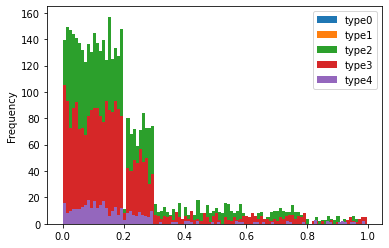

In [37]:
train.groupby('Compensation_and_Benefits')['Attrition_rate'].plot(kind='hist',bins=100)
plt.legend()

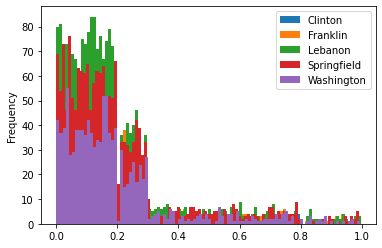

In [38]:
train.groupby('Hometown')['Attrition_rate'].plot(kind='hist',bins=100)
plt.legend()

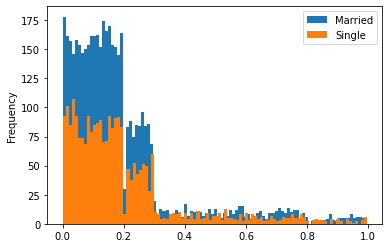

In [39]:
train.groupby('Relationship_Status')['Attrition_rate'].plot(kind='hist',bins=100)
plt.legend()

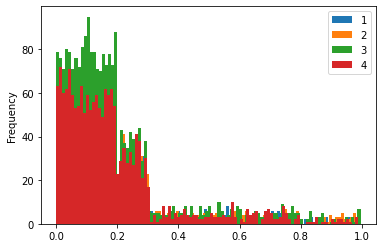

In [40]:
train.groupby('Agecat')['Attrition_rate'].plot(kind='hist',bins=100)
plt.legend()

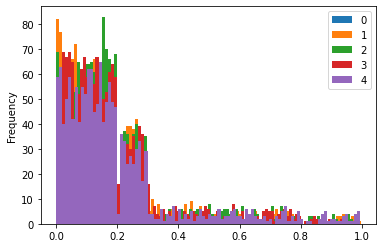

In [41]:
train.groupby('Time_since_promotion')['Attrition_rate'].plot(kind='hist',bins=100)
plt.legend()

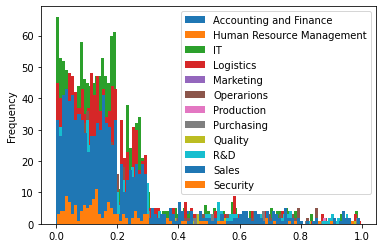

In [42]:
train.groupby('Unit')['Attrition_rate'].plot(kind='hist',bins=100)
plt.legend()

# More robust model

In [43]:
train=train.join(new)
test=test.join(newt)

In [44]:
cat_features=train.columns[train.dtypes==object]
for col in cat_features:
    le.fit(train[col])
    test[col]=le.transform(test[col])
    train[col]=le.transform(train[col])

In [45]:
test.isnull().sum()

Gender                                        0
Age                                           0
Education_Level                               0
Relationship_Status                           0
Hometown                                      0
                                             ..
Post_LevelCompensation_and_Benefits           0
Post_LevelWork_Life_balance                   0
Pay_ScaleCompensation_and_Benefits            0
Pay_ScaleWork_Life_balance                    0
Compensation_and_BenefitsWork_Life_balance    0
Length: 73, dtype: int64

In [46]:
_=train.copy()
_.dropna(inplace=True)

In [47]:
feature=_.drop('Attrition_rate',axis=1)
label=_.Attrition_rate

# Feature selection

In [48]:
feature.isnull().sum()

Gender                                        0
Age                                           0
Education_Level                               0
Relationship_Status                           0
Hometown                                      0
                                             ..
Post_LevelCompensation_and_Benefits           0
Post_LevelWork_Life_balance                   0
Pay_ScaleCompensation_and_Benefits            0
Pay_ScaleWork_Life_balance                    0
Compensation_and_BenefitsWork_Life_balance    0
Length: 73, dtype: int64

In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
dt=DecisionTreeRegressor()
rfe=RFE(dt,n_features_to_select=15,step=1).fit(feature,label)

In [50]:
selected_fea=feature.columns[rfe.support_]

# Final model validation

In [51]:
import xgboost as xgb
dmatrix=xgb.DMatrix(feature[selected_fea],label)
params={'objective':'reg:squarederror','max_depth':5,'colsample_bytree':.5,'eta':.02,'alpha':8}
result=xgb.cv(params,dmatrix,num_boost_round=1000,early_stopping_rounds=20,as_pandas=True,nfold=3)
result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.356633,0.000293,0.356633,0.000597
1,0.351478,0.000289,0.351480,0.000601
2,0.346455,0.000286,0.346459,0.000605
3,0.341561,0.000284,0.341566,0.000609
4,0.336793,0.000281,0.336800,0.000613
...,...,...,...,...
227,0.184108,0.000418,0.186208,0.000701
228,0.184095,0.000415,0.186207,0.000706
229,0.184079,0.000417,0.186209,0.000705
230,0.184066,0.000418,0.186208,0.000708


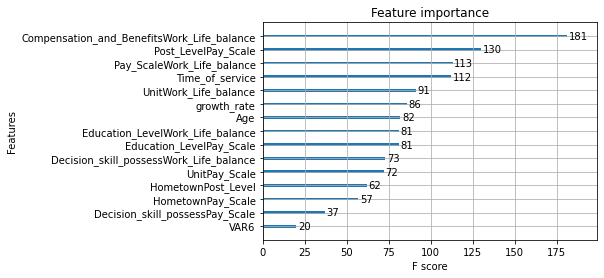

In [52]:
xgb_cl=xgb.train(params,dmatrix,num_boost_round=231)
xgb.plot_importance(xgb_cl)

selected_col=['Compensation_and_BenefitsWork_Life_balance','Post_LevelPay_Scale','Pay_ScaleWork_Life_balance','Time_of_service','UnitWork_Life_balance','growth_rate','Age','Education_LevelPay_Scale','Decision_skill_possessWork_Life_balance','UnitPay_Scale','HometownPost_Level','HometownPay_Scale','Decision_skill_possessPay_Scale','VAR6']

In [53]:
score=[]
for i in range(5):
    X_train,X_test,y_train,y_test=train_test_split(feature[selected_fea],label)
    lgb=LGBMRegressor(max_depth=5,learning_rate=.01,n_estimators=100,subsample_for_bin=3000,subsample=.6,colsample_bytree=.6,num_leaves=20)
    lgb.fit(X_train,y_train)
    y_pred=lgb.predict(X_test)
    score.append(np.sqrt(mean_squared_error(y_test,y_pred)))
score    

[0.1835777662399854,
 0.19026329073933698,
 0.18804235878800363,
 0.18197276132482593,
 0.19688215947906162]

# Final model

In [55]:
lgb.fit(feature[selected_fea],label)
y_pred=lgb.predict(test[selected_fea])

In [56]:
#y_pred=xgb_cl.predict(xgb.DMatrix(test[selected_fea]))
t=pd.read_csv(r'D:\Downloads\Compressed\attrition prediction\Dataset\Test.csv')
save=t[['Employee_ID']]
save['Attrition_rate']=y_pred
save.to_csv(r'C:\Users\pankaj\Desktop\Attrition rate\sellgb15newlgbrandomsea.csv',index=False)

C:\Users\pankaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Grid search

In [133]:
from sklearn.model_selection import GridSearchCV
params={'max_depth':[3,5,8],'learning_rate':[.1,.01,.2],'n_estimators':[50,100,300,500],'subsample_for_bin':[3000,5000,7000],'subsample':[.6,.8],'colsample_bytree':[.6,.8,1]}
gs=GridSearchCV(lgb,params,scoring='neg_mean_squared_error',n_jobs=-1).fit(feature[selected_fea],label)

In [134]:
gs.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 50,
 'subsample': 0.6,
 'subsample_for_bin': 3000}

 on old 10 feature lgb got 81.216